In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint


# 下載 bid 文件
file_id_bid = '1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx'
url_bid = f"https://drive.google.com/uc?export=download&id={file_id_bid}"
output_bid = 'data_bid.csv'
gdown.download(url_bid, output_bid, quiet=False)

# 下載 ask 文件
file_id_ask = '1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c'
url_ask = f"https://drive.google.com/uc?export=download&id={file_id_ask}"
output_ask = 'data_ask.csv'
gdown.download(url_ask, output_ask, quiet=False)

# 讀取下載的文件
data_bid = pd.read_csv('data_bid.csv')
data_ask = pd.read_csv('data_ask.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx
To: /content/data_bid.csv
100%|██████████| 37.6M/37.6M [00:00<00:00, 44.8MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c
To: /content/data_ask.csv
100%|██████████| 37.5M/37.5M [00:00<00:00, 87.2MB/s]


Training set size: 336615
Test set size: 37400
Accuracy:  0.6490641711229946
Confusion Matrix: 
 [[10858     0  7120]
 [  239     0   451]
 [ 5315     0 13417]]


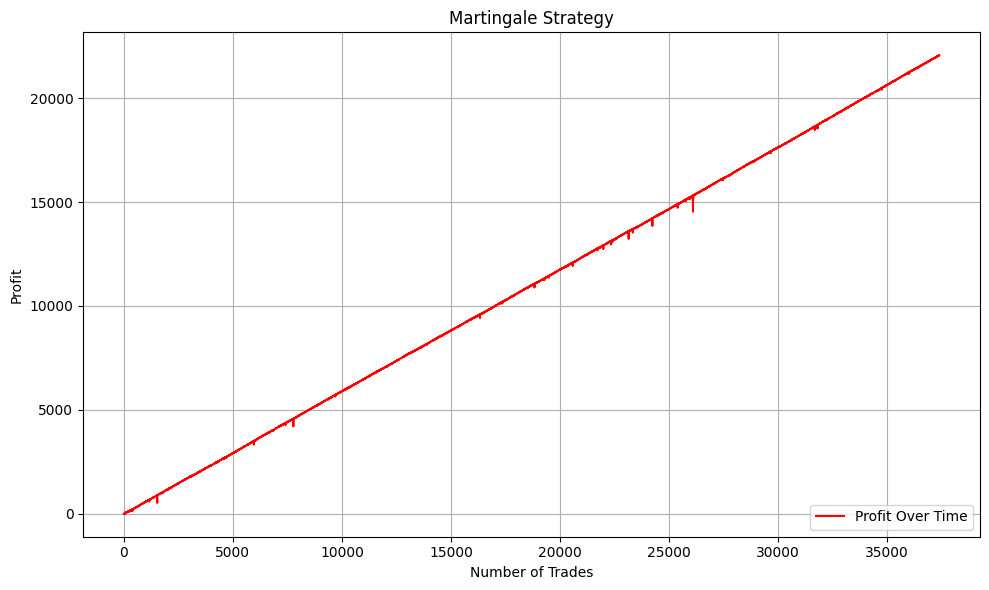

Martingale final profit: 22066.83


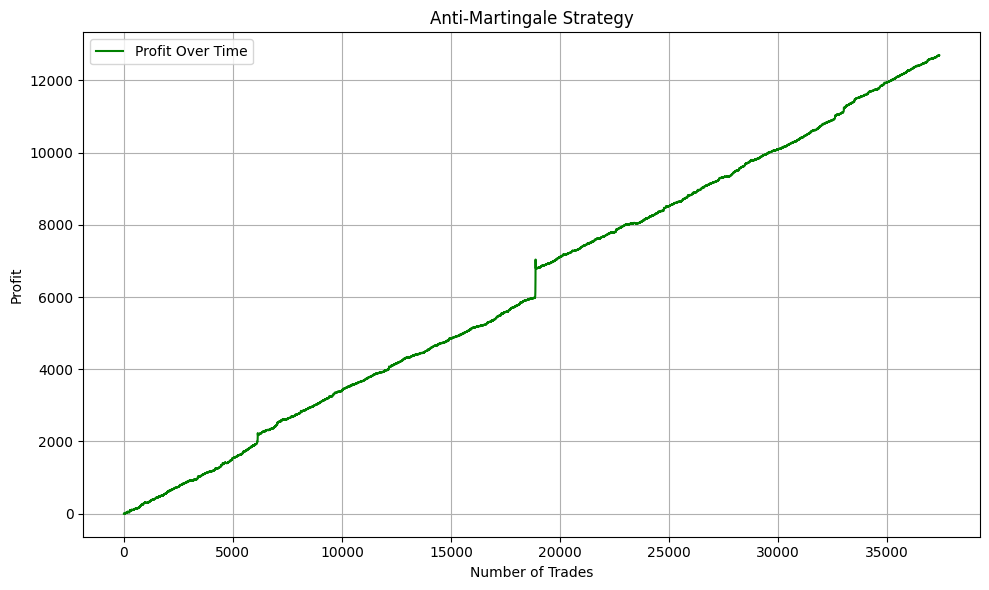

Anti-Martingale final profit: 12692.99
凱利最終本金: 5005594669040.11


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 3
run_analysis(shift_value)


Training set size: 336608
Test set size: 37393
Accuracy:  0.5820608135212473
Confusion Matrix: 
 [[ 8472     0  9407]
 [  112     0   268]
 [ 5841     0 13293]]


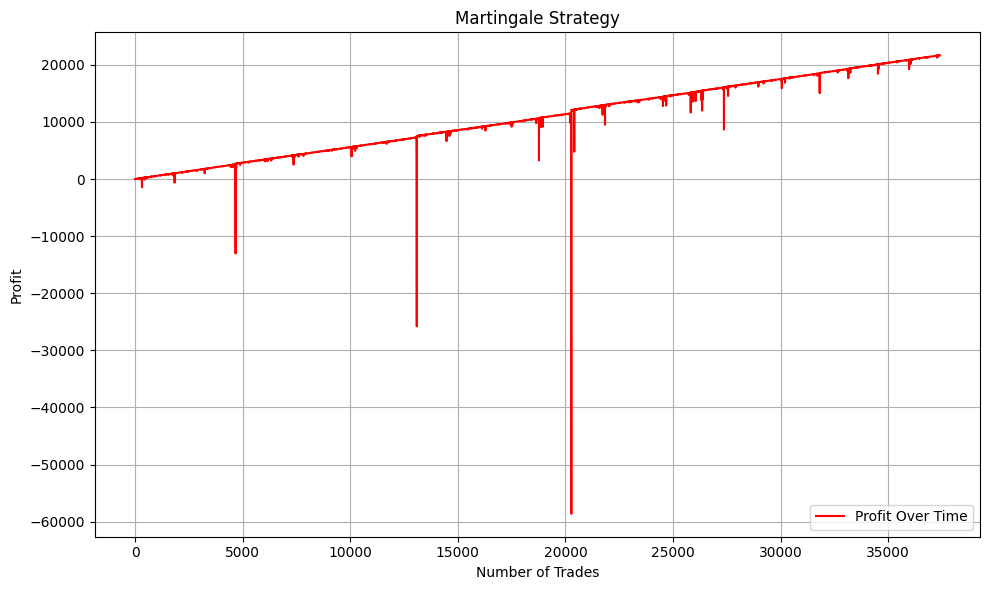

Martingale final profit: 21672.93


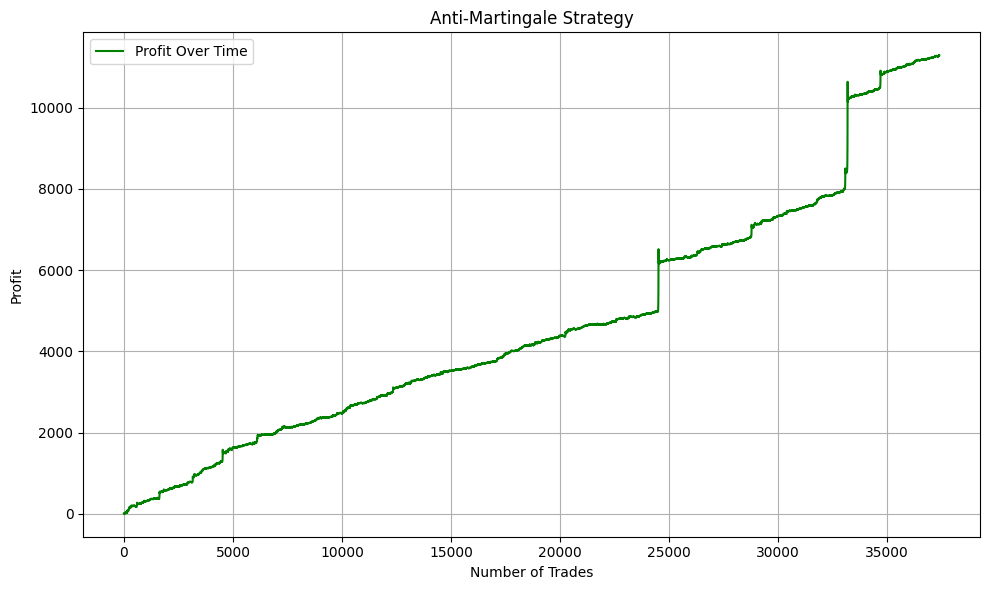

Anti-Martingale final profit: 11292.72
凱利最終本金: 301635.78


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 10
run_analysis(shift_value)


Training set size: 336598
Test set size: 37383
Accuracy:  0.5547708851617045
Confusion Matrix: 
 [[ 6993     0 10808]
 [   57     0   178]
 [ 5601     0 13746]]


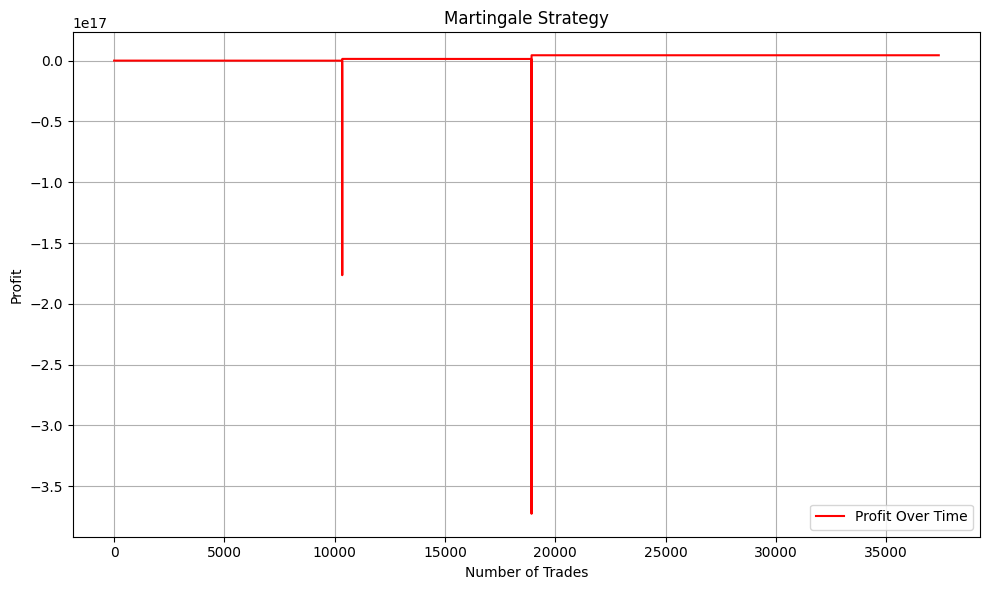

Martingale final profit: 4403814553807871.50


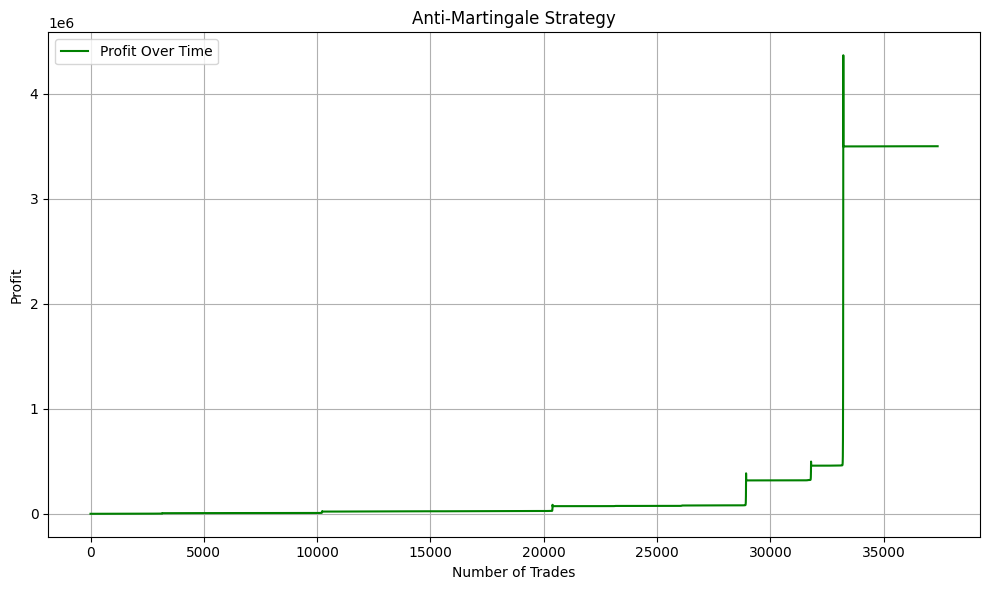

Anti-Martingale final profit: 3500573.23
凱利最終本金: 9066.85


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 20
run_analysis(shift_value)


Training set size: 336588
Test set size: 37373
Accuracy:  0.5389184705536082
Confusion Matrix: 
 [[ 7498     0 10178]
 [   61     0   150]
 [ 6843     0 12643]]


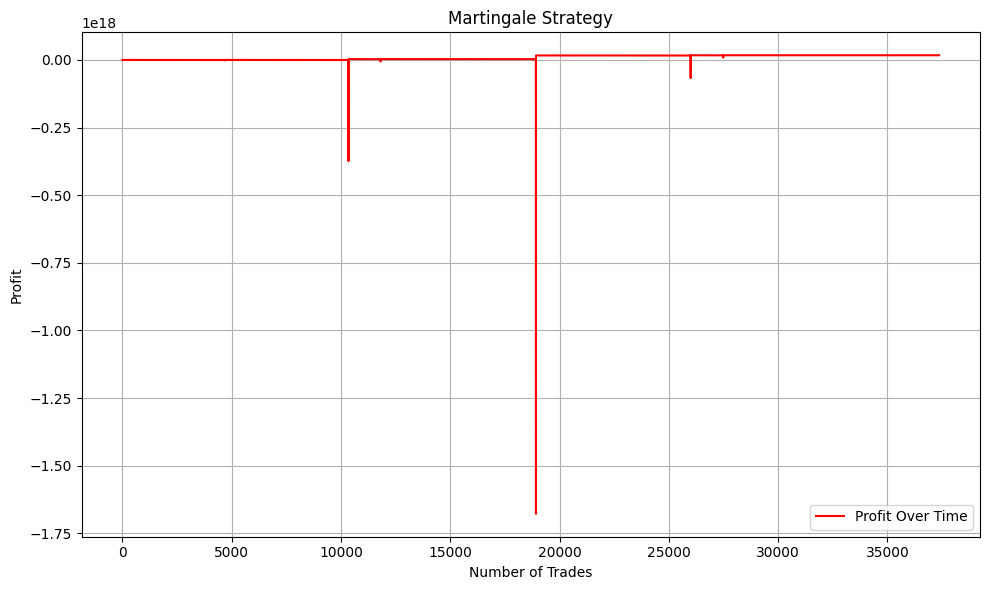

Martingale final profit: 17277750890596294.00


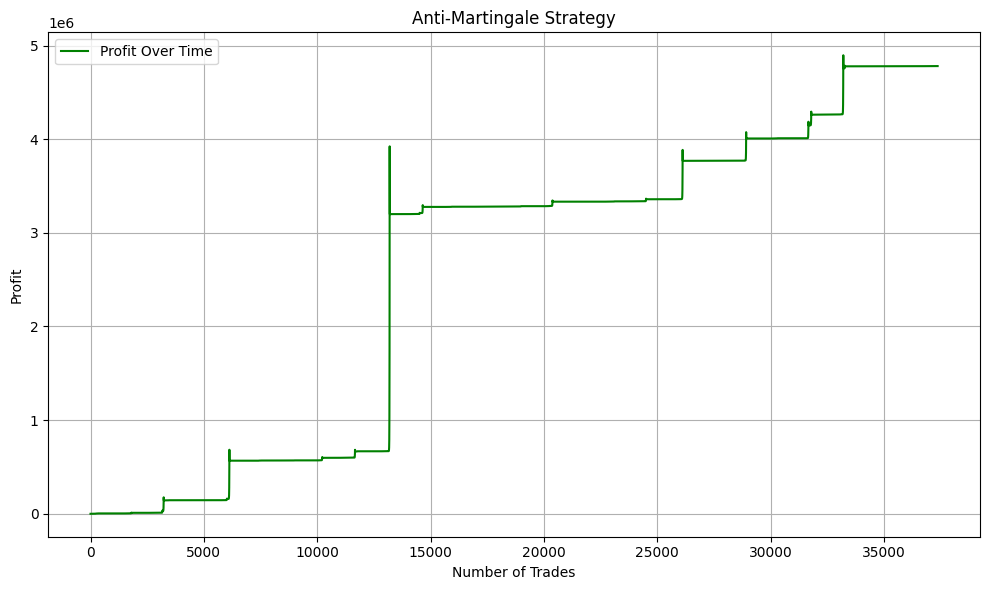

Anti-Martingale final profit: 4780555.74
凱利最終本金: 5153.82


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 30
run_analysis(shift_value)


Training set size: 336578
Test set size: 37363
Accuracy:  0.5289457484677355
Confusion Matrix: 
 [[ 7019     0 10455]
 [   42     0   134]
 [ 6969     0 12744]]


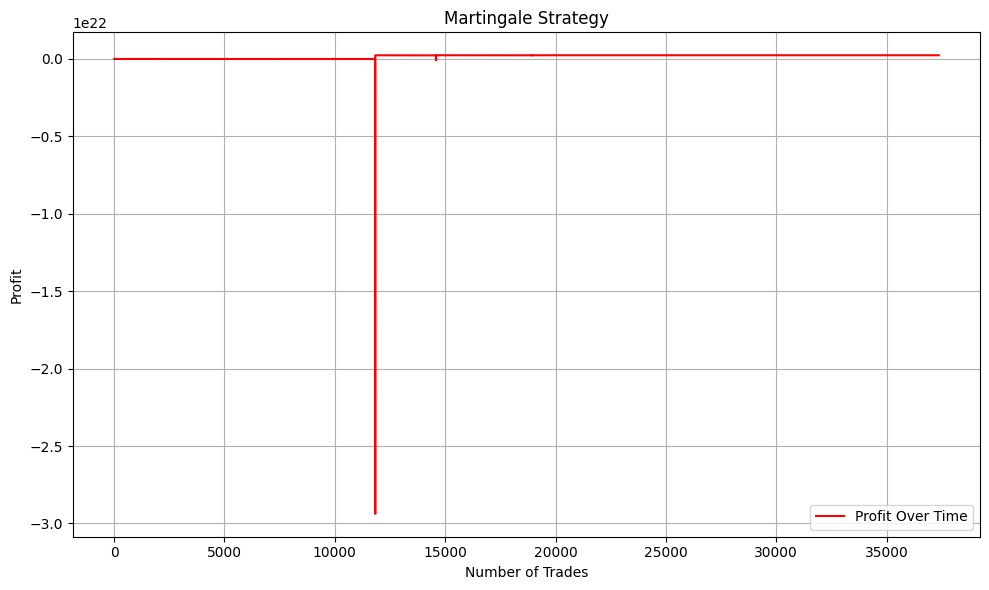

Martingale final profit: 237718796586699489280.00


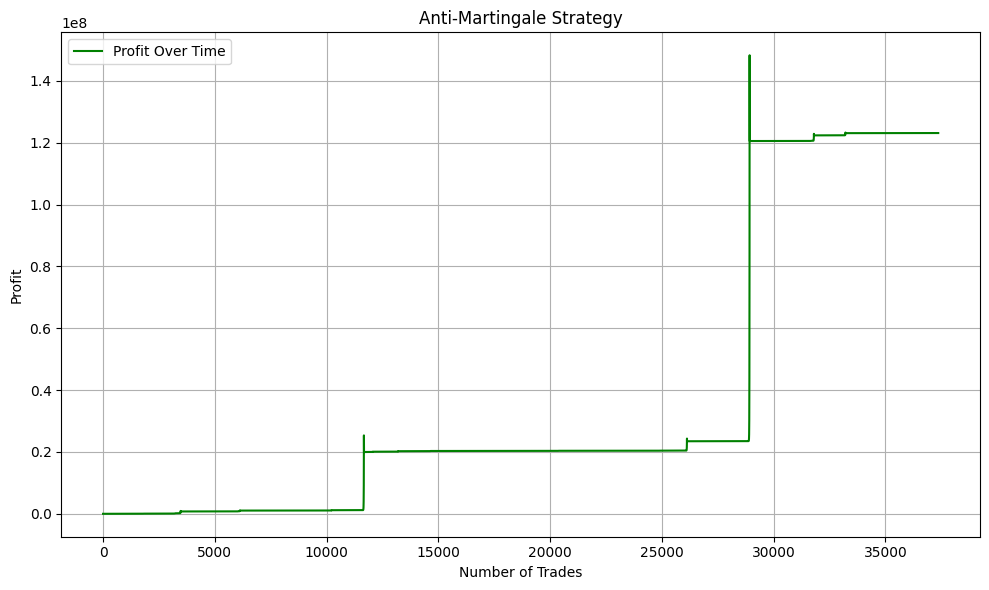

Anti-Martingale final profit: 123138027.21
凱利最終本金: 5382.03


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 40
run_analysis(shift_value)


Training set size: 336568
Test set size: 37353
Accuracy:  0.5214842181350896
Confusion Matrix: 
 [[ 6730     0 10620]
 [   47     0    95]
 [ 7112     0 12749]]


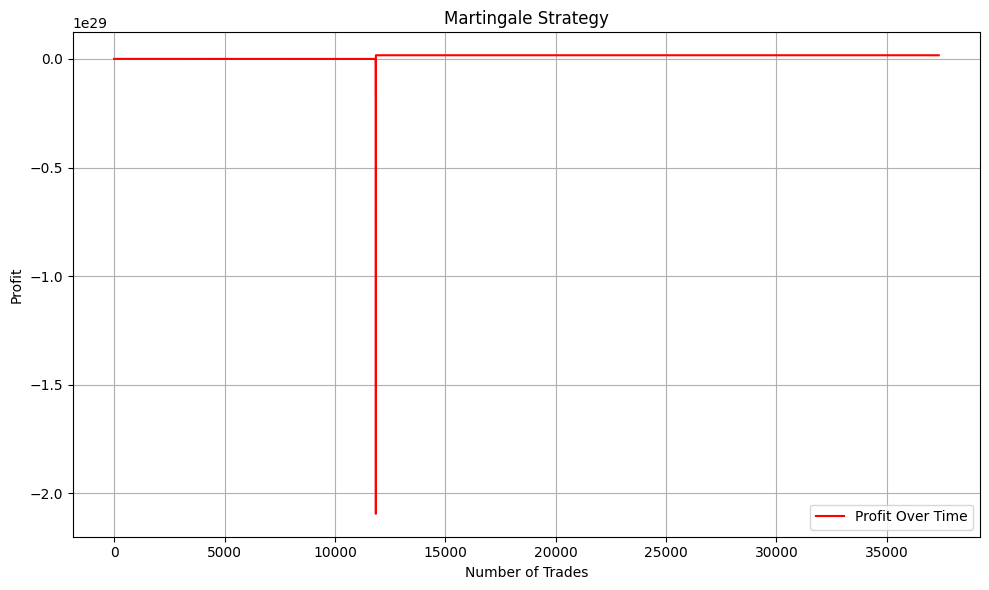

Martingale final profit: 1675329199078041691887763456.00


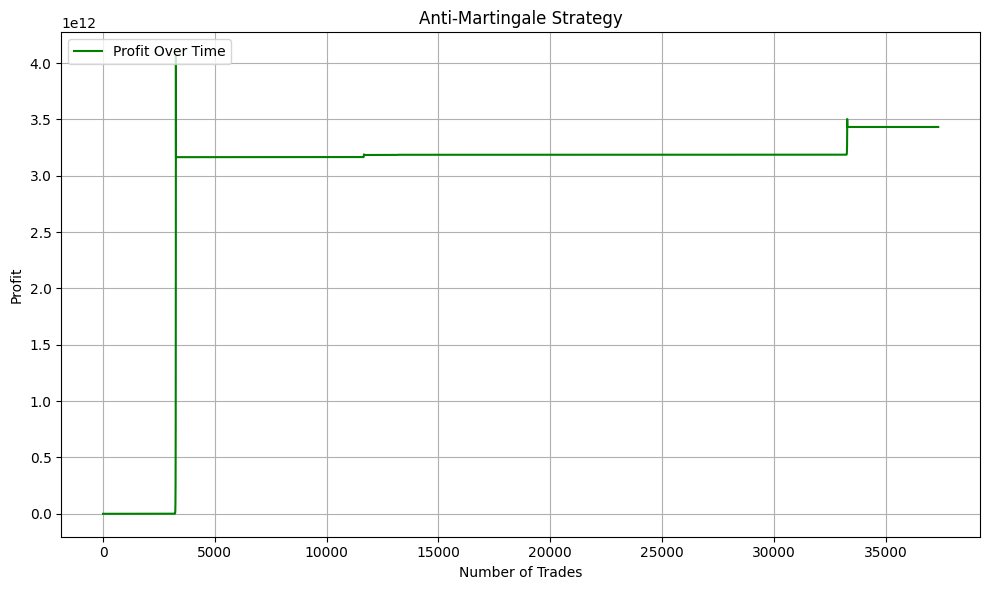

Anti-Martingale final profit: 3433338778047.01
凱利最終本金: 3256.45


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 50
run_analysis(shift_value)


Training set size: 336558
Test set size: 37343
Accuracy:  0.5267386123235948
Confusion Matrix: 
 [[ 7118     0 10188]
 [   34     0   101]
 [ 7350     0 12552]]


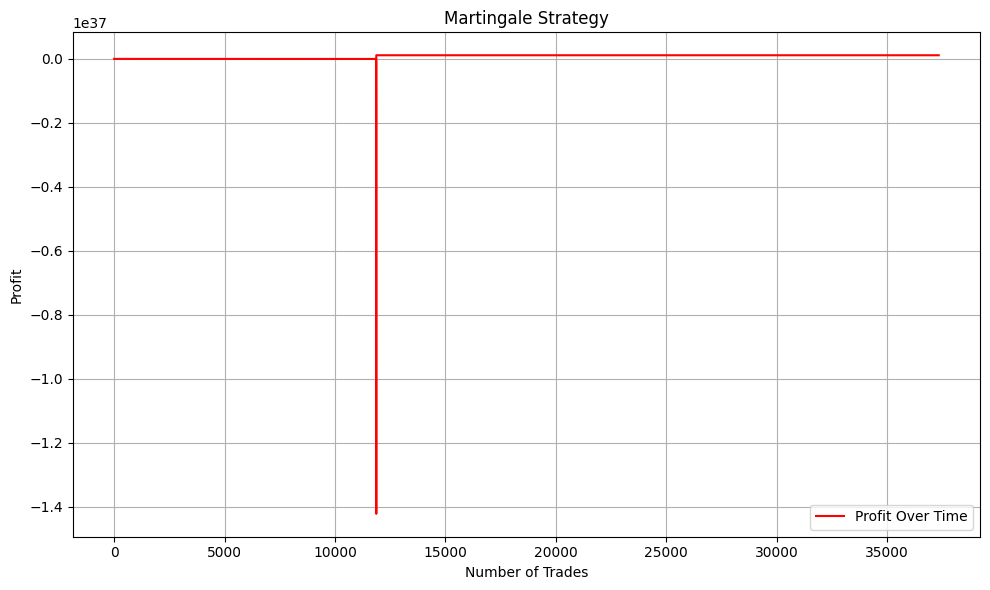

Martingale final profit: 113804680479397013250450618723598336.00


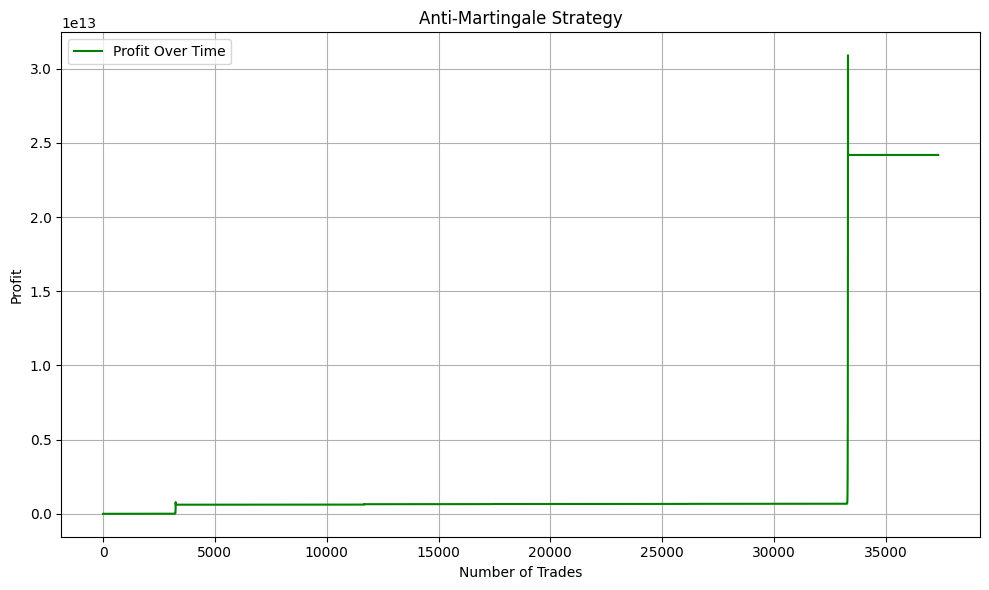

Anti-Martingale final profit: 24190591411697.05
凱利最終本金: 4361.42


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 60
run_analysis(shift_value)


Training set size: 336498
Test set size: 37283
Accuracy:  0.5071748518091356
Confusion Matrix: 
 [[ 6622     0 10643]
 [   24     0    76]
 [ 7631     0 12287]]


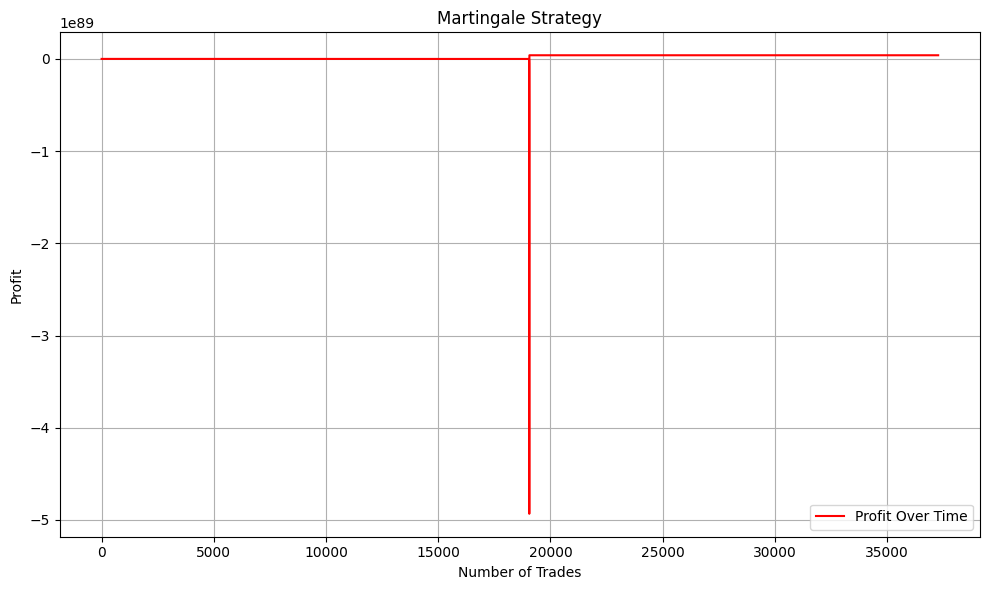

Martingale final profit: 3946696401909216296737002057740120721672762923035124188284955733763580789825552538140672.00


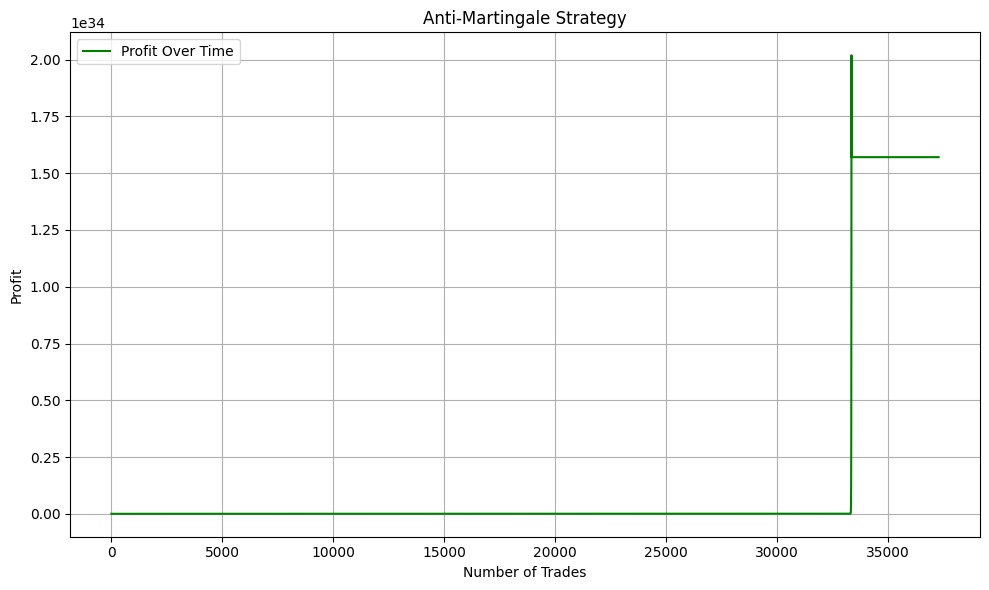

Anti-Martingale final profit: 15707161586646218140957315436642304.00
凱利最終本金: 8399.13


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 120
run_analysis(shift_value)


Training set size: 336378
Test set size: 37163
Accuracy:  0.4934477840863224
Confusion Matrix: 
 [[ 7256     0  9818]
 [   10     0    47]
 [ 8950     0 11082]]


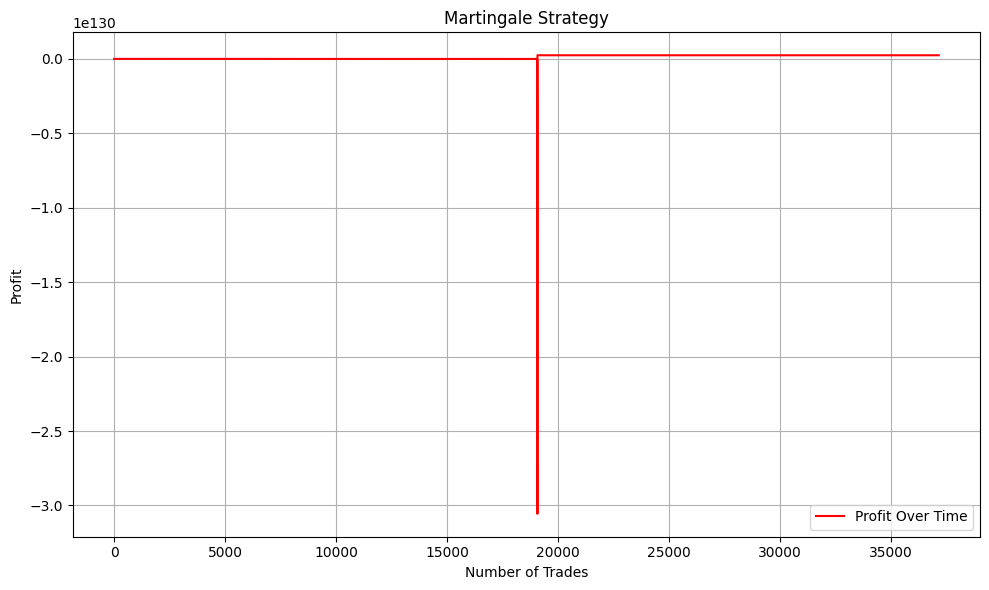

Martingale final profit: 244464800596240165732157988995579174894894173853732745724568282525909991214389378199544293032651516555754093149293050117729812480.00


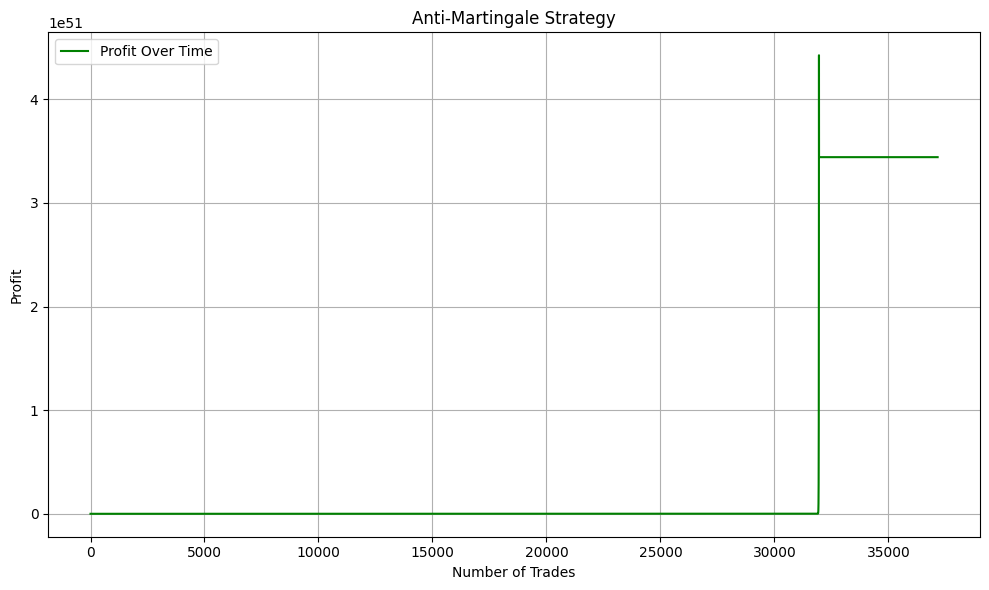

Anti-Martingale final profit: 3441838585409867587217819137623831908609021160980480.00
凱利最終本金: 0.21


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 240
run_analysis(shift_value)


Training set size: 336258
Test set size: 37043
Accuracy:  0.4816024620036174
Confusion Matrix: 
 [[ 7795     0  9561]
 [   11     0    37]
 [ 9594     0 10045]]


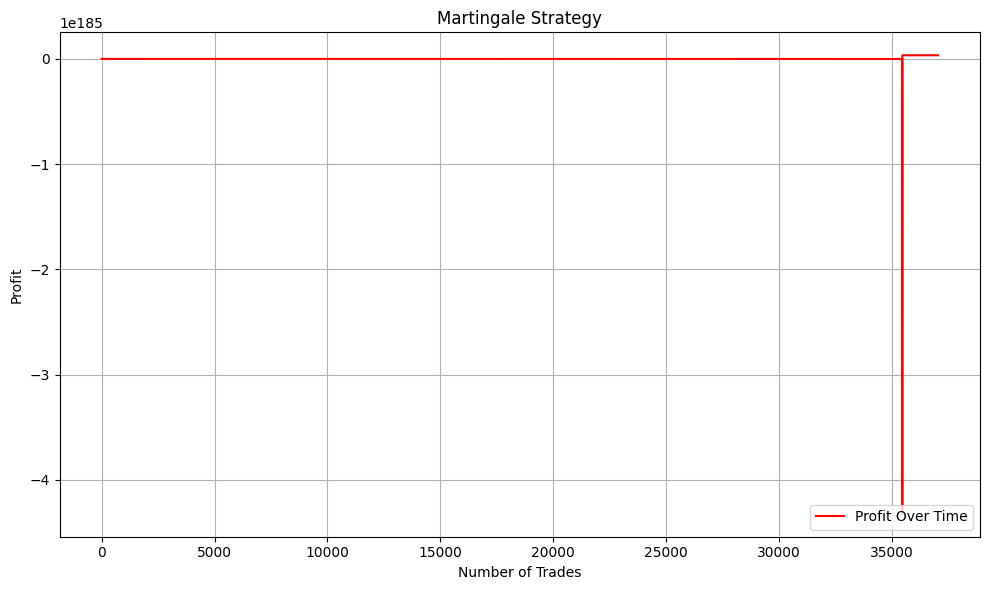

Martingale final profit: 3459209243578426538531737259034284695088815666291173689632022284871329726404447476085748136062608271658314695919060480846213772495435550389985115060897194849397282225807297532284370944.00


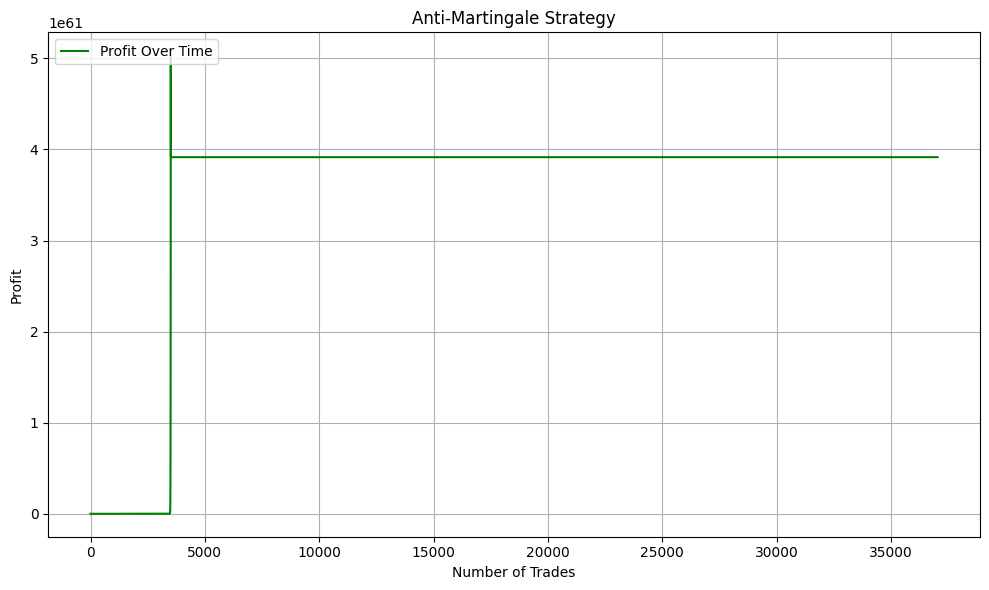

Anti-Martingale final profit: 39156940262913997854396293296000517956773937601363253298987008.00
凱利最終本金: 1143737237648.53


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 360
run_analysis(shift_value)


Training set size: 336138
Test set size: 36923
Accuracy:  0.4862822630880481
Confusion Matrix: 
 [[8008    0 9163]
 [  18    0   38]
 [9749    0 9947]]


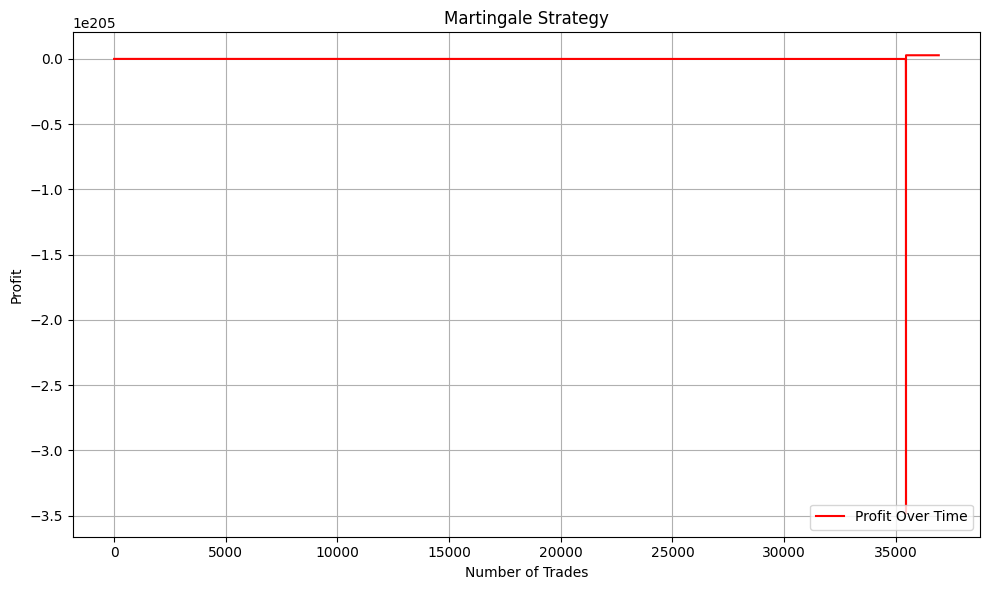

Martingale final profit: 278910169388226803872073620768252712108217206643181089571187069693824286767741491553439493708260339509285662911023556683268076073981647497429312347639028667184755470306411076801186671382423510265962168320.00


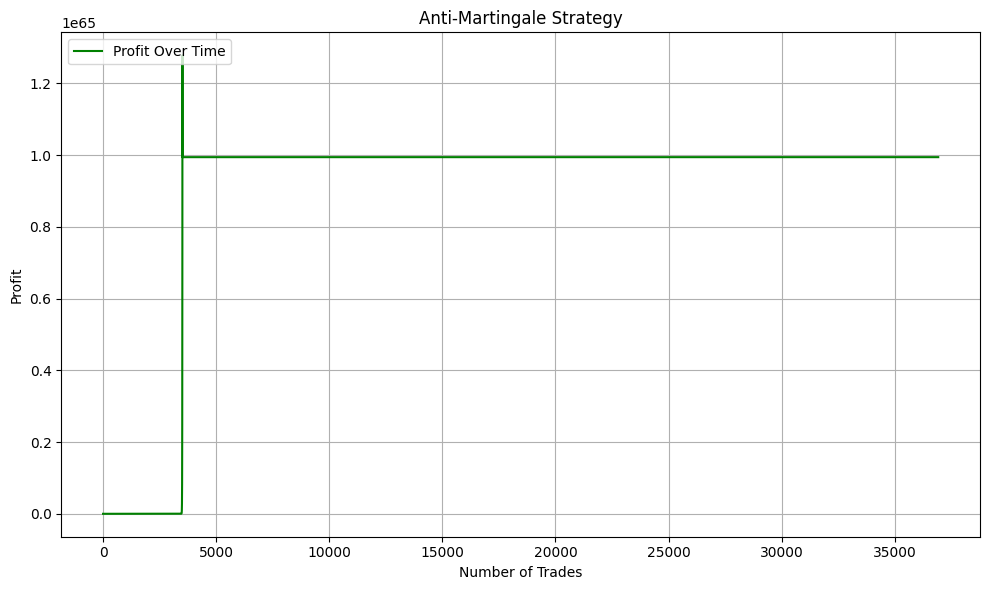

Anti-Martingale final profit: 99449439590973926267754377151394605021573965378212511464231534592.00
凱利最終本金: 76348505561614336584040054784.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 480
run_analysis(shift_value)


Training set size: 336018
Test set size: 36803
Accuracy:  0.48251501236312255
Confusion Matrix: 
 [[ 8446     0  8520]
 [   13     0    31]
 [10481     0  9312]]


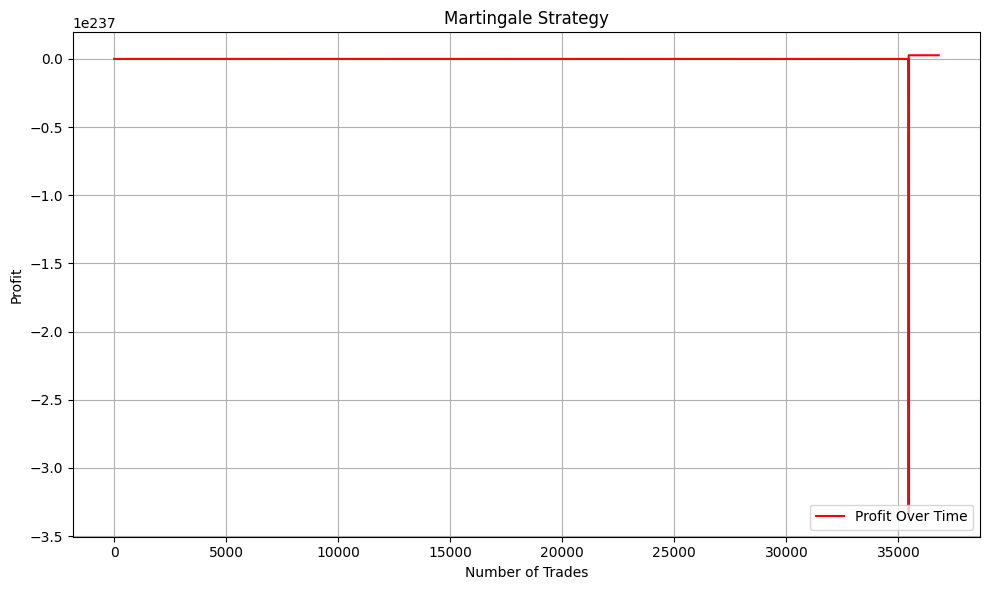

Martingale final profit: 26691852757652363944373665979730485229474834315112603756310055890709292715832486556337102202466378676350924895655912411179809494909945454627873700615000338222834282656981896319012033395473743794136947942625781157783394593256748848513024.00


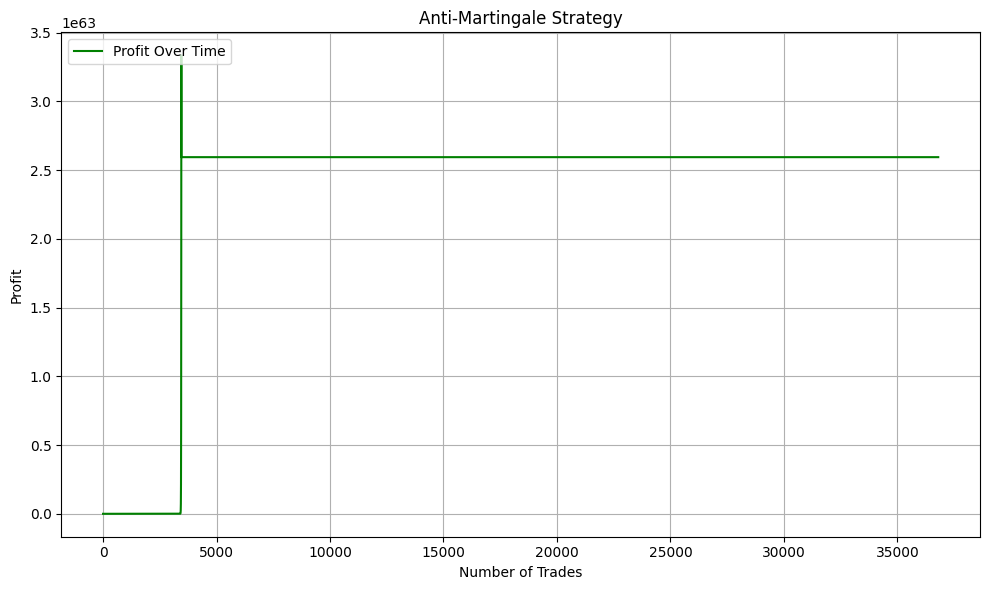

Anti-Martingale final profit: 2594053662763786909740089834949962555869773193252740823408181248.00
凱利最終本金: 6367278742017981764599808000.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 600
run_analysis(shift_value)


Training set size: 335898
Test set size: 36683
Accuracy:  0.493471090150751
Confusion Matrix: 
 [[ 8231     0  8450]
 [   16     0    23]
 [10092     0  9871]]


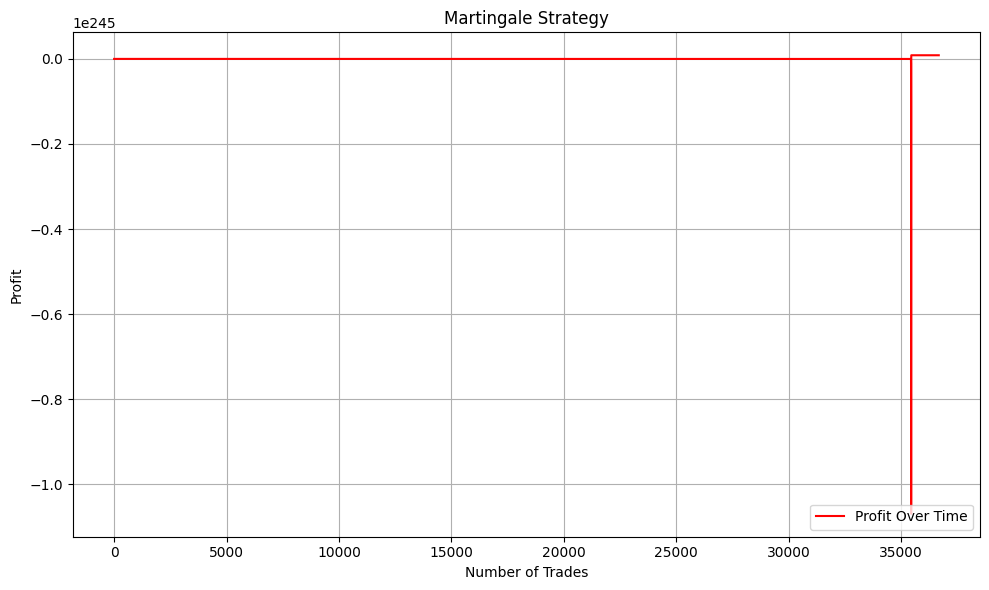

Martingale final profit: 855374327897087013052707609625273131716539296397846844340629838419047175624690572226772105202288899327823041778215267964980409234964569079550976365971099263614379117100220657519368780107251613821861747109500373554128124615133484926966473687040.00


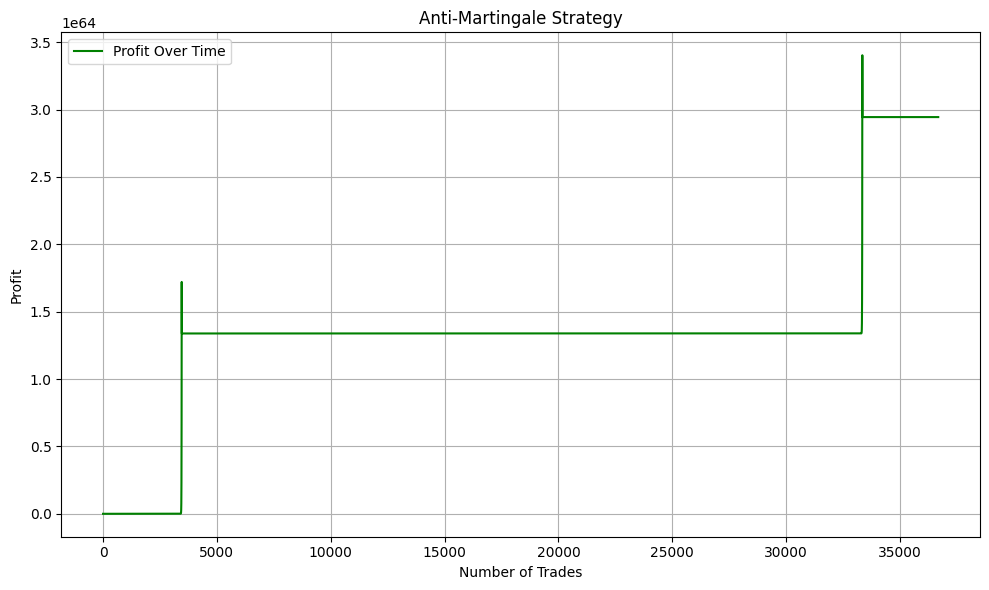

Anti-Martingale final profit: 29446417722546125652618975077557876232255817808461628795414118400.00
凱利最終本金: 51013900697138338797191168.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 720
run_analysis(shift_value)


Training set size: 335778
Test set size: 36563
Accuracy:  0.5113092470530317
Confusion Matrix: 
 [[ 8732     0  7558]
 [   30     0     8]
 [10272     0  9963]]


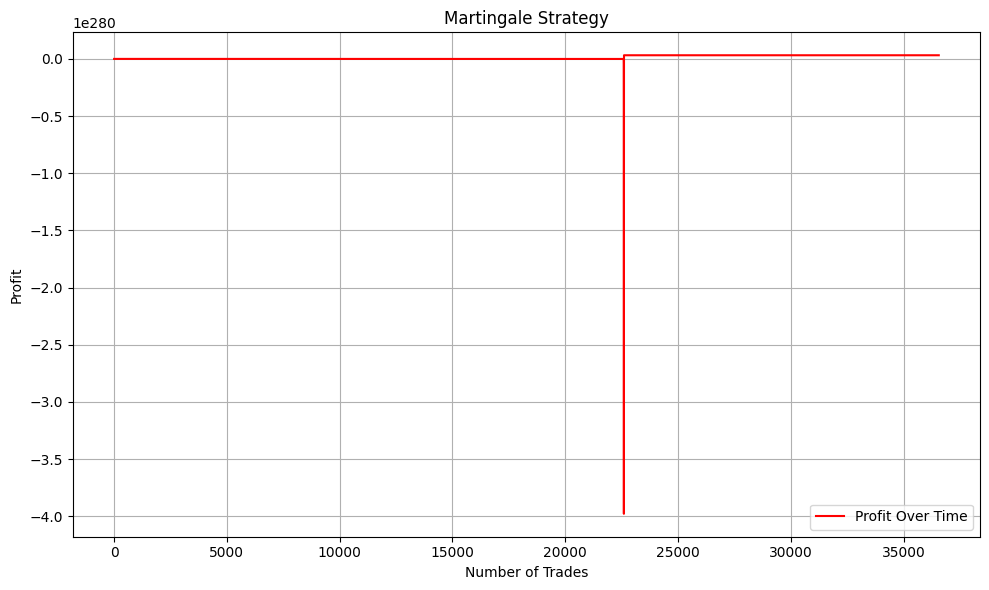

Martingale final profit: 318208974993145241606979519903146324189099099323898441623621254579863521342387660929939082608998473029817026610956114483233785578890888525084614004755824172345626870975382440447965133392644116367787998057597422574361405080401492754106608197158914298834421010408009506353666064384.00


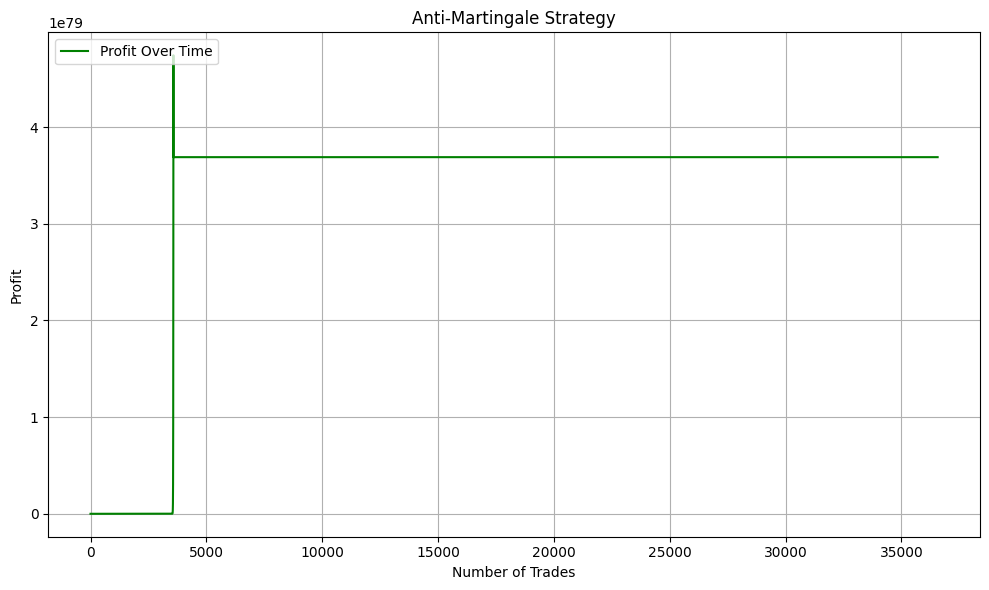

Anti-Martingale final profit: 36893648000766778001571586209864475203775037214185086034313496891344960696090624.00
凱利最終本金: 2635733284279602176.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 840
run_analysis(shift_value)


Training set size: 335658
Test set size: 36443
Accuracy:  0.4973245890843235
Confusion Matrix: 
 [[ 8720     0  6998]
 [   24     0    10]
 [11287     0  9404]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


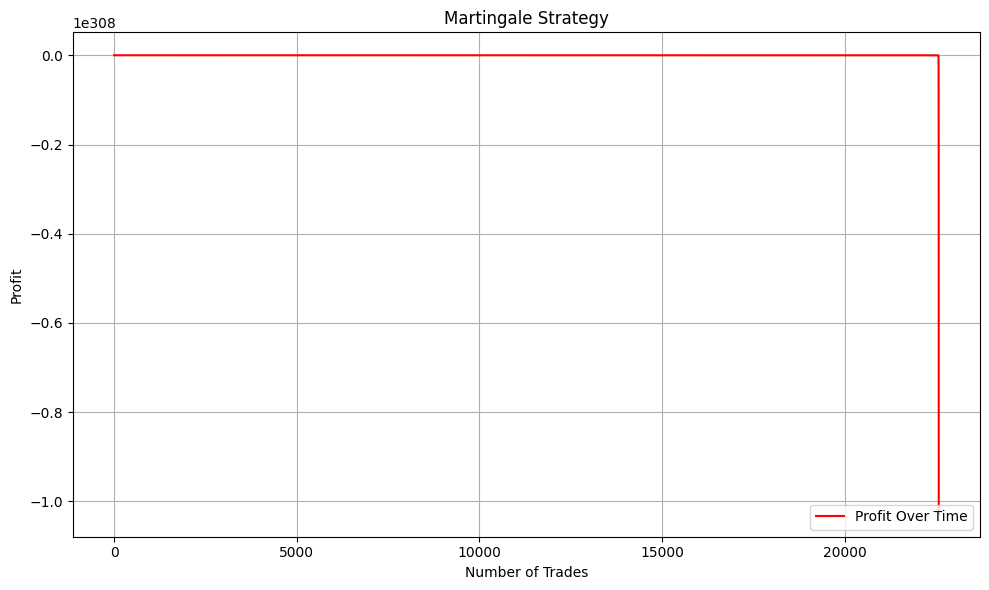

Martingale final profit: nan


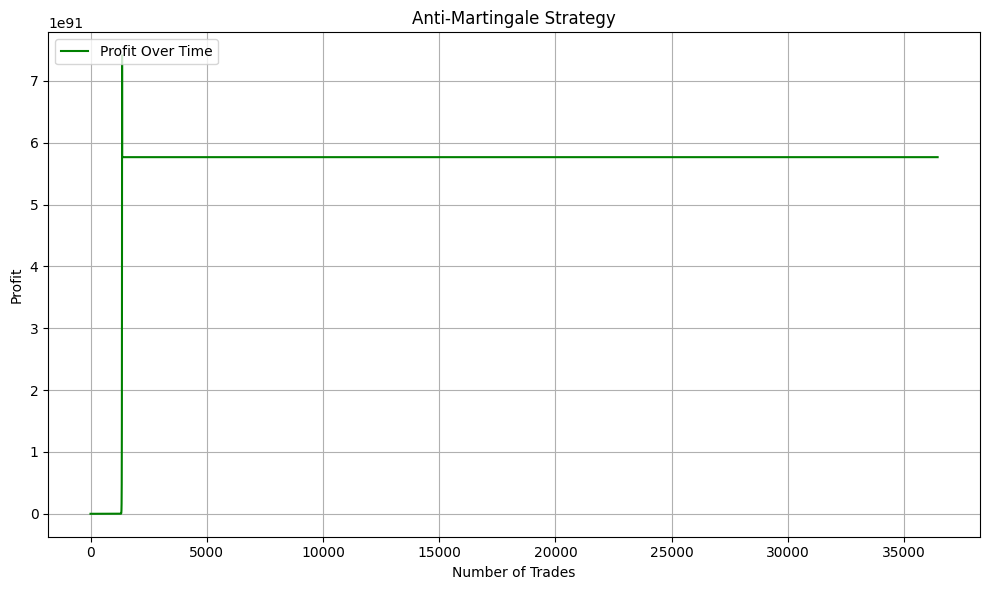

Anti-Martingale final profit: 57658520117485105658312696815967899449468655491877261993378786564736699712269274954921410560.00
凱利最終本金: 194174482435635396214784.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 960
run_analysis(shift_value)


Training set size: 335538
Test set size: 36323
Accuracy:  0.46240673953142636
Confusion Matrix: 
 [[ 9686     0  5573]
 [   32     0     5]
 [13917     0  7110]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


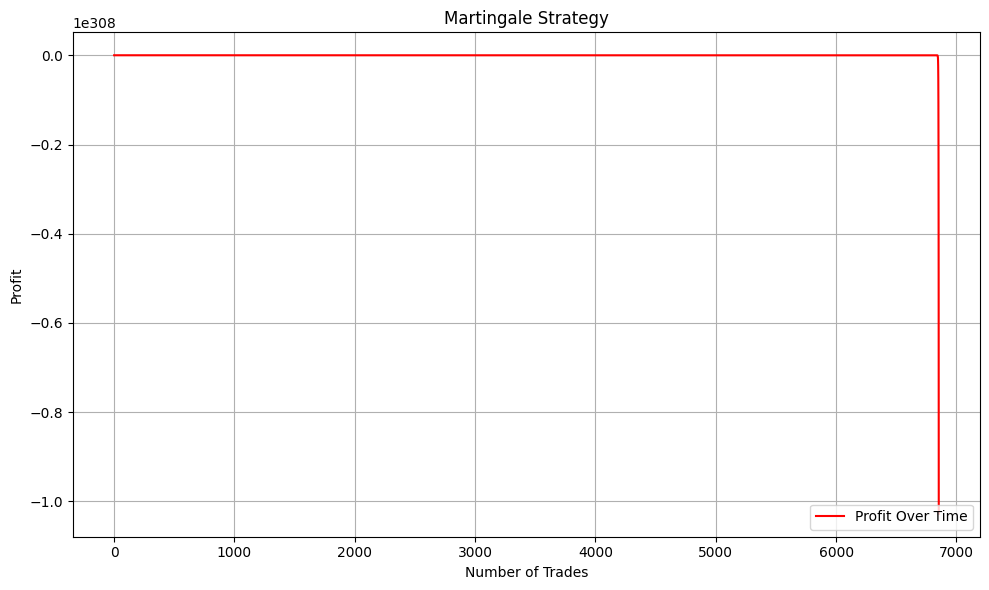

Martingale final profit: nan


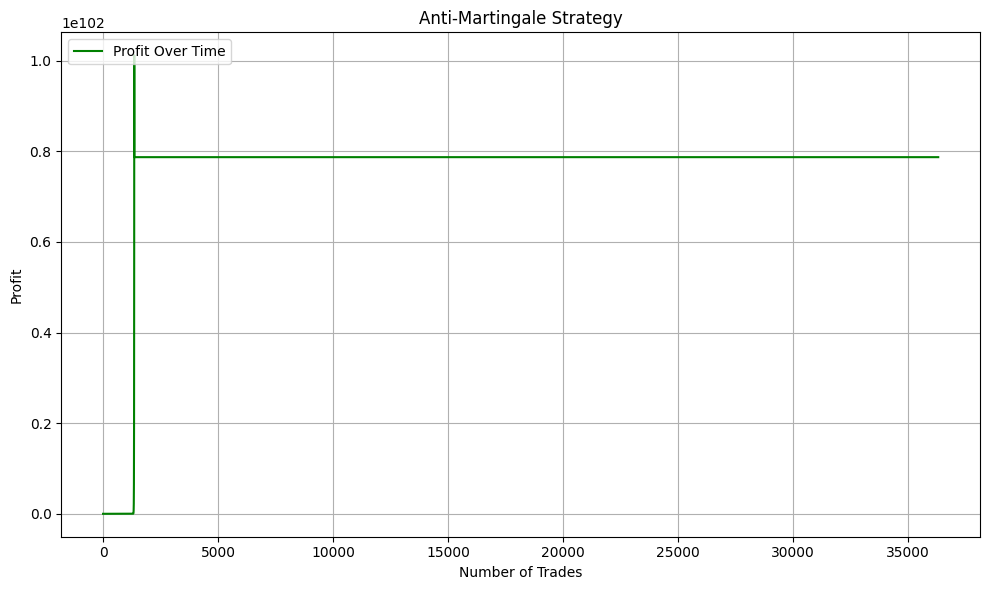

Anti-Martingale final profit: 787159942465119285084258701507788589860370180951529461997286888147866337974379544896364677026310782976.00
凱利最終本金: 16545382743458985448057439074123776.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1080
run_analysis(shift_value)


Training set size: 335364
Test set size: 36196
Accuracy:  0.46969278373300916
Confusion Matrix: 
 [[ 9499     0  5189]
 [   30     0    13]
 [13963     0  7502]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


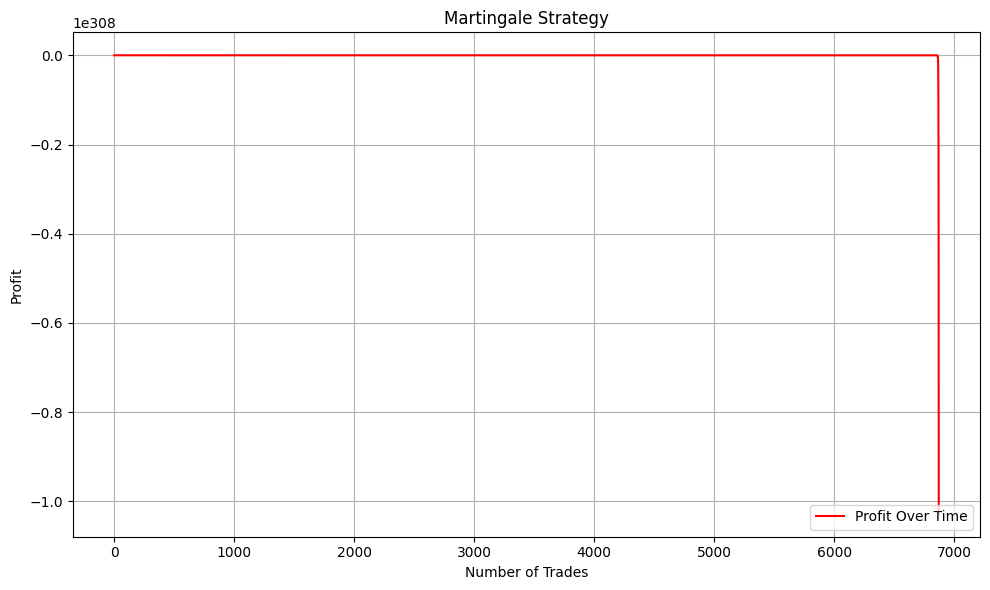

Martingale final profit: nan


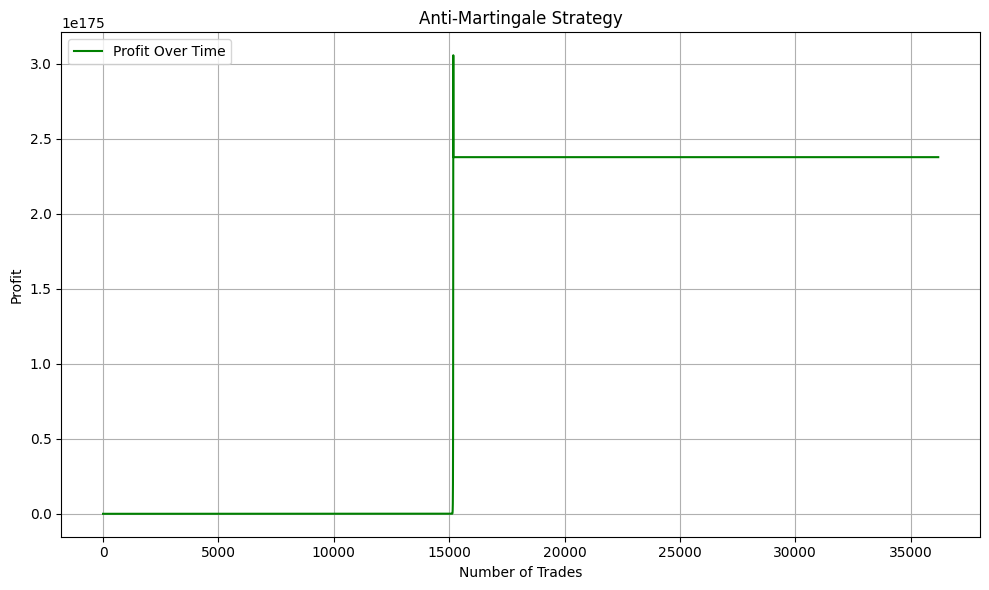

Anti-Martingale final profit: 23782599232323890962967353064075978534995467467592427944015773010941481745928186854329468854066301788715317408029114563316889880306029829663775168387461494570765642980904665088.00
凱利最終本金: 584754156720088334030849147448898617344.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1200
run_analysis(shift_value)


Training set size: 335136
Test set size: 36064
Accuracy:  0.47645851818988466
Confusion Matrix: 
 [[10326     0  4228]
 [   25     0     6]
 [14622     0  6857]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


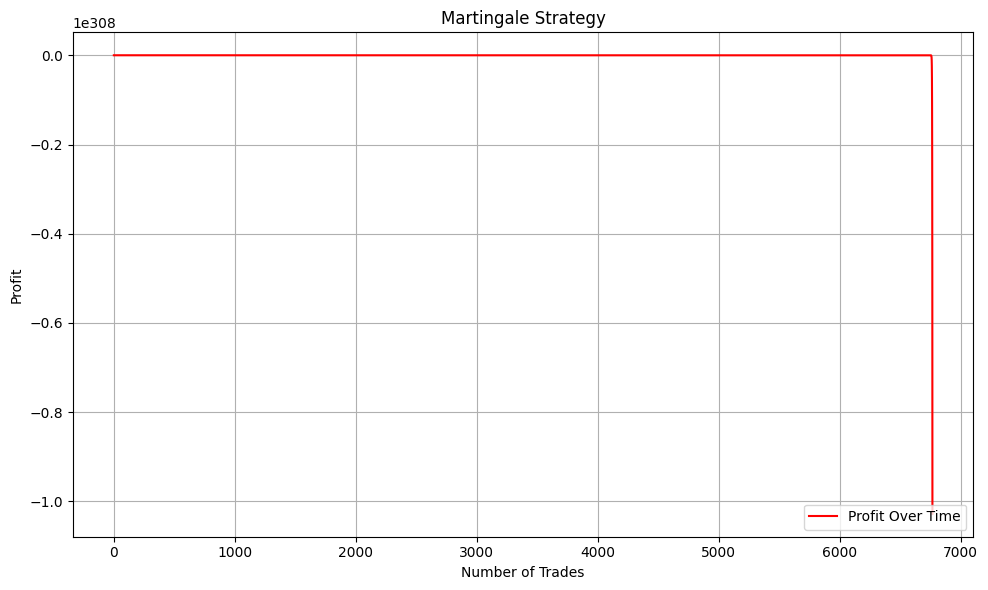

Martingale final profit: nan


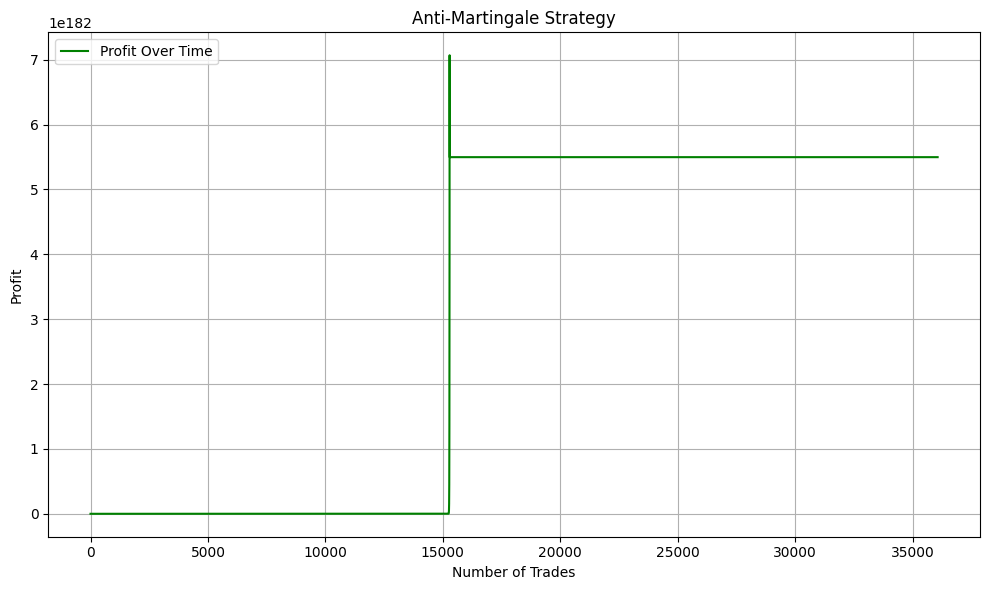

Anti-Martingale final profit: 549686663115039174644199858826219366435263542488388586384197175316722060120569207395170707877021140109569119954586942607955201051290453718469140371071930750016919284623233031463763968.00
凱利最終本金: 27275951391559225788551771571060335443968.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # 邏輯回歸模型
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Training set size:', len(train_data))
    print('Test set size:', len(test_data))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")


    # 凱利策略
    probabilities = model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1320
run_analysis(shift_value)
